Script di bawah ini berfungsi untuk mengunduh dan memasang library yang diperlukan untuk pengolahan citra, analisis data, visualisasi, dan machine learning.

In [1]:
pip install scikit-learn scikit-image scipy seaborn matplotlib numpy opencv-python pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Script di atas digunakan untuk mengimpor berbagai library yang diperlukan dalam project pengolahan citra dan machine learning. Library seperti os digunakan untuk mengelola file dan folder, cv2 (OpenCV) untuk membaca dan memproses citra, matplotlib.pyplot dan seaborn untuk visualisasi data dan grafik, serta numpy dan pandas untuk manipulasi data numerik dan tabel. Selain itu, berbagai modul dari scikit-learn diimpor untuk membagi data, membangun model klasifikasi (Random Forest, SVM, KNN), serta melakukan evaluasi model menggunakan metrik seperti akurasi, precision, recall, f1-score, dan confusion matrix. Library skimage.feature digunakan untuk ekstraksi fitur tekstur citra, sedangkan scipy.stats menyediakan fungsi statistik seperti entropy. Seluruh library ini saling melengkapi untuk mendukung proses analisis, pelatihan, dan evaluasi model klasifikasi citra digital.

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [2]:
data_awal = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue
        
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, (256, 700))  
        
        data_awal.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data_awal = np.array(data_awal)
labels = np.array(labels)

data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data_awal)):
	pass



Script di atas digunakan untuk memuat seluruh gambar dari folder dataset yang sudah dikelompokkan berdasarkan labelnya. Setiap gambar dibaca dari subfolder, kemudian dikonversi ke format grayscale dan diubah ukurannya menjadi 256x700 piksel agar seragam. Nama file dan label dari setiap gambar juga disimpan ke dalam list. Seluruh data gambar, label, dan nama file kemudian diubah menjadi array numpy agar mudah diproses pada tahap selanjutnya. Selain itu, kode juga menyiapkan variabel untuk data augmentasi, meskipun proses augmentasi belum diimplementasikan pada bagian ini.

# Augmentasi


## Data Preparation

### Define Preprocessing Function


In [ ]:
def histogram_equalization(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    cdf = hist.cumsum()
    cdf_normalized = ((cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())).astype(np.uint8)
    equalized = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized[i, j] = cdf_normalized[img[i, j]]
    return equalized

def median_filter(image, ksize):
    pad = ksize // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+ksize, j:j+ksize]
            median_val = np.median(window)
            output[i, j] = median_val
    return output

def thresholding(img, threshold):
    result = np.zeros_like(img, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] >= threshold:
                result[i, j] = 255
            else:
                result[i, j] = 0
    return result


Kode di atas berisi tiga fungsi. Fungsi histogram_equalization meningkatkan kontras gambar dengan meratakan distribusi intensitas piksel berdasarkan histogram dan fungsi distribusi kumulatif (CDF). Fungsi median_filter mengurangi noise dengan mengganti setiap piksel menggunakan median dari lingkungan sekitarnya dalam jendela ukuran tertentu. Fungsi thresholding mengubah gambar grayscale menjadi biner berdasarkan ambang tertentu, di mana piksel yang nilainya di atas ambang akan menjadi putih (255) dan sisanya menjadi hitam (0).

### Preprocessing

In [ ]:
preprocessed_data = []

for img in data_awal:
    img_eq = histogram_equalization(img)       
    img_med = median_filter(img_eq, ksize=3)    
    thres_img = thresholding(img_med, 87)
    preprocessed_data.append(thres_img)

preprocessed_data = np.array(preprocessed_data)

Kode di atas melakukan preprocessing pada kumpulan citra yang disimpan dalam data_awal. Untuk setiap gambar, pertama dilakukan peningkatan kontras menggunakan histogram equalization, kemudian hasilnya difilter dengan median filter berukuran 3x3 untuk mengurangi noise, dan selanjutnya diterapkan thresholding dengan nilai ambang 87 untuk menghasilkan gambar biner. Hasil dari setiap gambar yang telah diproses disimpan ke dalam list preprocessed_data.

### Feature Extraction

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi glcm di atas digunakan untuk menghitung matriks GLCM (Gray Level Co-occurrence Matrix) dari sebuah citra grayscale pada sudut tertentu (0, 45, 90, atau 135 derajat). Fungsi ini akan menentukan sudut berdasarkan input, lalu memanggil graycomatrix dari library skimage untuk menghasilkan matriks GLCM dengan jarak 1 piksel, 256 level keabuan, simetris, dan ternormalisasi. Matriks GLCM ini nantinya digunakan untuk ekstraksi fitur tekstur citra seperti kontras, homogenitas, dan lainnya.

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi correlation di atas digunakan untuk menghitung nilai korelasi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti correlation, lalu mengembalikan nilai korelasi pada posisi [0, 0] dari hasil tersebut. Nilai korelasi ini menggambarkan tingkat hubungan linier antara piksel-piksel pada citra dan sering digunakan sebagai salah satu fitur tekstur dalam analisis citra.

In [8]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi dissimilarity di atas digunakan untuk menghitung nilai dissimilarity dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti 'dissimilarity', lalu mengembalikan nilai pada posisi [0, 0]. Nilai dissimilarity ini menggambarkan tingkat perbedaan intensitas antara pasangan piksel pada citra dan sering digunakan sebagai salah satu fitur tekstur dalam analisis citra.

In [9]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi homogenity di atas digunakan untuk menghitung nilai homogenitas dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti 'homogeneity', lalu mengembalikan nilai pada posisi [0, 0]. Nilai homogenitas ini menunjukkan seberapa seragam atau mirip nilai intensitas antar piksel pada citra, dan sering digunakan sebagai salah satu fitur tekstur dalam analisis citra.

In [10]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi contrast di atas digunakan untuk menghitung nilai kontras dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti 'contrast', lalu mengembalikan nilai pada posisi [0, 0]. Nilai kontras ini menunjukkan perbedaan intensitas antara piksel-piksel pada citra dan sering digunakan sebagai salah satu fitur tekstur dalam analisis citra.

In [11]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ASM di atas digunakan untuk menghitung nilai ASM (Angular Second Moment) dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti 'ASM', lalu mengembalikan nilai pada posisi [0, 0]. Nilai ASM ini menunjukkan tingkat keseragaman atau konsistensi tekstur pada citra, di mana nilai yang tinggi menandakan tekstur yang lebih seragam.

In [12]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi energy di atas digunakan untuk menghitung nilai energy dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini memanfaatkan graycoprops dari library skimage untuk mengambil properti 'energy', lalu mengembalikan nilai pada posisi [0, 0]. Nilai energy ini menunjukkan tingkat keseragaman tekstur pada citra, di mana nilai yang tinggi menandakan tekstur yang lebih seragam.

In [13]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi entropyGlcm di atas digunakan untuk menghitung nilai entropi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang diberikan sebagai input. Fungsi ini menggunakan entropy dari scipy.stats pada matriks yang telah diratakan (flattened) menjadi satu dimensi dengan .ravel(). Nilai entropi ini menggambarkan tingkat ketidakpastian atau kompleksitas tekstur pada citra; semakin tinggi nilai entropi, semakin kompleks tekstur citra tersebut.

In [14]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(preprocessed_data)):
    D0 = glcm(preprocessed_data[i], 0)
    D45 = glcm(preprocessed_data[i], 45)
    D90 = glcm(preprocessed_data[i], 90)
    D135 = glcm(preprocessed_data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Script di atas digunakan untuk menghitung matriks GLCM (Gray Level Co-occurrence Matrix) dari setiap gambar hasil preprocessing pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Setiap gambar diproses satu per satu, lalu hasil GLCM untuk masing-masing sudut disimpan ke dalam list yang berbeda (Derajat0, Derajat45, Derajat90, Derajat135). Dengan cara ini, kita bisa mendapatkan informasi tekstur citra dari berbagai arah sehingga fitur yang diekstrak menjadi lebih lengkap dan representatif.

In [15]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Script di atas digunakan untuk menyiapkan list kosong yang akan menampung hasil ekstraksi berbagai fitur tekstur dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur seperti kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi akan memiliki empat list sesuai sudutnya, sehingga hasil ekstraksi dari setiap gambar dan setiap sudut bisa disimpan secara terpisah dan terstruktur sebelum nantinya digabungkan ke dalam tabel fitur.

In [16]:
for i in range(len(preprocessed_data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Script di atas digunakan untuk menghitung nilai fitur korelasi dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar hasil preprocessing. Pada setiap iterasi, fungsi correlation dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (correlation0, correlation45, correlation90, correlation135). Dengan cara ini, setiap gambar akan memiliki nilai korelasi tekstur dari empat arah yang berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [17]:
for i in range(len(data_awal)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Script di atas digunakan untuk menghitung nilai fitur kontras dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi contrast dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (Kontras0, Kontras45, Kontras90, Kontras135). Dengan cara ini, setiap gambar akan memiliki nilai kontras tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [18]:
for i in range(len(data_awal)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Script di atas digunakan untuk menghitung nilai fitur dissimilarity dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi dissimilarity dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135). Dengan cara ini, setiap gambar akan memiliki nilai dissimilarity tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [19]:
for i in range(len(data_awal)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Script di atas Kode tersebut digunakan untuk menghitung nilai fitur homogenitas dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi homogenity dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (homogenity0, homogenity45, homogenity90, homogenity135). Dengan cara ini, setiap gambar akan memiliki nilai homogenitas tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [20]:
for i in range(len(data_awal)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Script di atas digunakan untuk menghitung nilai fitur entropi dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi entropyGlcm dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (entropy0, entropy45, entropy90, entropy135). Dengan cara ini, setiap gambar akan memiliki nilai entropi tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [21]:
for i in range(len(data_awal)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Script di atas digunakan untuk menghitung nilai fitur ASM (Angular Second Moment) dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi ASM dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (ASM0, ASM45, ASM90, ASM135). Dengan cara ini, setiap gambar akan memiliki nilai ASM tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

In [22]:
for i in range(len(data_awal)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Script di atas digunakan untuk menghitung nilai fitur energy dari matriks GLCM pada setiap sudut (0°, 45°, 90°, dan 135°) untuk seluruh gambar yang ada di data_awal. Pada setiap iterasi, fungsi energy dipanggil untuk masing-masing matriks GLCM (Derajat0, Derajat45, Derajat90, Derajat135) dan hasilnya dimasukkan ke dalam list yang sesuai (energy0, energy45, energy90, energy135). Dengan cara ini, setiap gambar akan memiliki nilai energy tekstur dari empat arah berbeda, yang nantinya digunakan sebagai fitur dalam proses analisis atau klasifikasi citra.

### Write the extraction's results to CSV 

Script di bawah di gunakan untuk membuat sebuah dictionary dataTable yang berisi seluruh fitur hasil ekstraksi tekstur GLCM (seperti Contrast, Homogeneity, Dissimilarity, Entropy, ASM, Energy, Correlation) dari empat sudut berbeda (0°, 45°, 90°, 135°) beserta nama file dan labelnya. Dictionary ini kemudian dikonversi menjadi DataFrame pandas dan disimpan ke file CSV bernama hasil_ekstraksi_1.csv. Setelah itu, file CSV dibaca kembali ke dalam DataFrame hasilEkstrak untuk ditampilkan atau digunakan pada proses selanjutnya (misal seleksi fitur atau pelatihan model).

In [23]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,"N1,N,40,M_1_0.jpg",NormalFinal,832.392857,1398.304721,1137.021778,1374.957082,0.987199,0.978496,0.982514,0.978855,...,0.537905,0.534859,0.736917,0.731106,0.733420,0.731341,0.971189,0.951616,0.960698,0.952423
1,"N1,N,F,21_1_0.jpg",NormalFinal,1136.935714,1955.364807,1492.045836,1702.918455,0.982516,0.969929,0.977055,0.973812,...,0.531124,0.528873,0.732930,0.724713,0.728783,0.727237,0.960765,0.932519,0.948605,0.941231
2,"N11,N,F,26_1_0.jpg",NormalFinal,1031.292857,1846.652361,1567.629258,1911.587983,0.984140,0.971601,0.975892,0.970603,...,0.531182,0.526697,0.734716,0.726387,0.728823,0.725739,0.964326,0.936149,0.945860,0.933903
3,"N12,N,F,14_1_0.jpg",NormalFinal,866.635714,1572.317597,1310.354916,1564.291845,0.986672,0.975820,0.979849,0.975944,...,0.535001,0.531853,0.736382,0.729202,0.731438,0.729283,0.970023,0.945622,0.954741,0.945900
4,"N12,N,M,13_1_0.jpg",NormalFinal,980.657143,1536.566524,1253.303967,1603.690987,0.984919,0.976370,0.980726,0.975338,...,0.535171,0.530867,0.735000,0.729280,0.731554,0.728606,0.966104,0.946907,0.956777,0.944588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,"N90, Rt TAIS, F, 14 Yrs.jpg",ScolFinal,1316.892857,1700.364807,1090.508902,1693.433476,0.979748,0.973851,0.983230,0.973958,...,0.537412,0.529245,0.731055,0.727424,0.733084,0.727492,0.954563,0.941289,0.962406,0.941528
138,"N91, Rt TAIS, M, 15 Yrs.jpg",ScolFinal,1093.585714,1435.150215,961.144967,1511.394850,0.983182,0.977930,0.985219,0.976757,...,0.535759,0.528095,0.730821,0.727472,0.731956,0.726701,0.962574,0.950867,0.967129,0.948256
139,"N94, Rt TAIS, F, 15 Yrs.jpg",ScolFinal,1741.650000,2516.802575,1861.968549,2647.403433,0.973216,0.961295,0.971366,0.959287,...,0.524703,0.514221,0.725675,0.718380,0.724364,0.717092,0.940124,0.913358,0.936009,0.908862
140,"N98, Rt TAIS, F, 14 Yrs.jpg",ScolFinal,998.507143,1454.120172,1126.120323,1584.356223,0.984644,0.977638,0.982682,0.975635,...,0.535341,0.529140,0.733268,0.728730,0.731670,0.727420,0.965662,0.949982,0.961312,0.945502


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Script di bawah digunakan untuk melakukan seleksi fitur dengan cara menghilangkan fitur-fitur yang memiliki korelasi sangat tinggi (lebih dari 0.95) satu sama lain, sehingga hanya fitur yang unik dan tidak redundant yang dipilih. Pertama, kode menghitung matriks korelasi antar fitur (tanpa label dan nama file), lalu menandai fitur yang korelasinya sangat tinggi agar tidak dipilih ganda. Hasil seleksi fitur disimpan ke variabel x_new, sedangkan label ke y. Terakhir, korelasi antar fitur yang terpilih divisualisasikan dalam bentuk heatmap agar mudah dianalisis.

<Axes: >

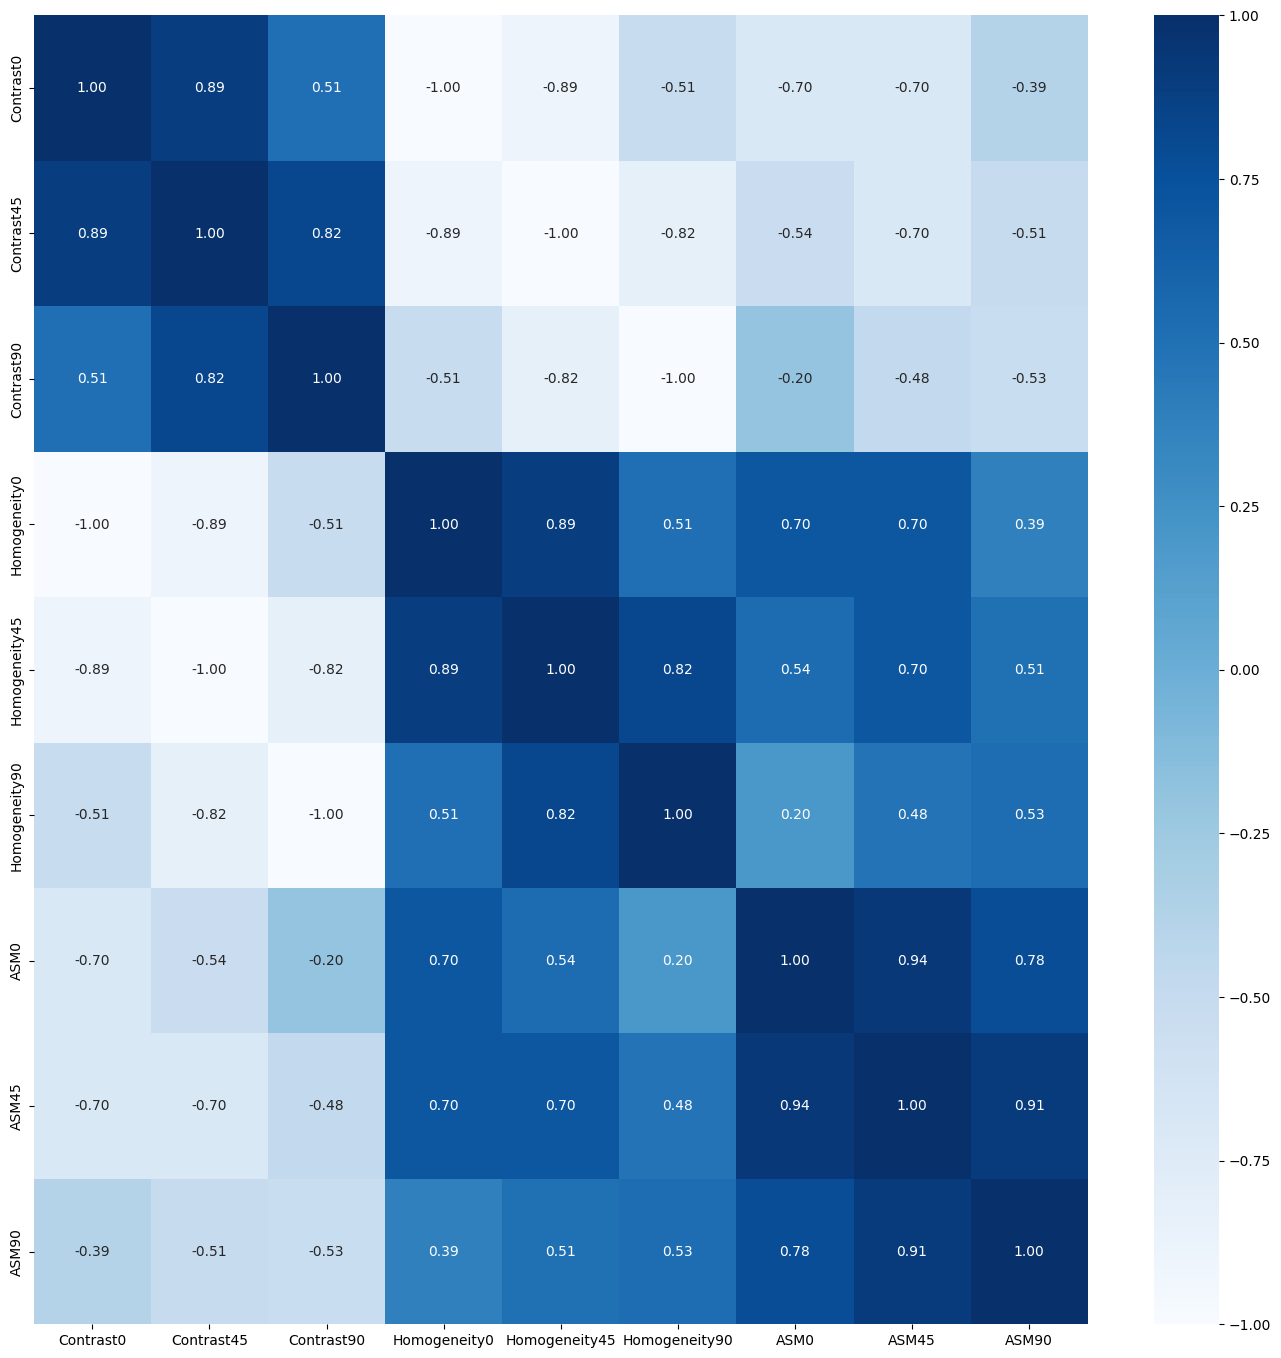

In [24]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

Script di bawah digunakan untuk membagi data fitur (x_new) dan label (y) menjadi data latih (train) dan data uji (test) dengan proporsi 80% untuk training dan 20% untuk testing. Fungsi train_test_split dari scikit-learn digunakan untuk melakukan pembagian ini secara acak namun tetap konsisten karena menggunakan random_state=42. Setelah data dibagi, bentuk (jumlah baris dan kolom) dari data training dan testing ditampilkan menggunakan print(X_train.shape) dan print(X_test.shape).

In [25]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(113, 9)
(29, 9)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [26]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Script di atas digunakan untuk melakukan normalisasi data fitur menggunakan metode standardisasi (Z-score), yaitu dengan mengurangi setiap nilai fitur pada data uji (X_test) dan data latih (X_train) dengan rata-rata (mean) data latih, lalu membaginya dengan standar deviasi (std) data latih. Tujuannya agar setiap fitur memiliki distribusi dengan rata-rata 0 dan standar deviasi 1, sehingga model machine learning dapat bekerja lebih optimal dan tidak bias terhadap fitur dengan skala yang lebih besar.

## Modeling

### Define Model

In [27]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Script di atas ini digunakan untuk mendefinisikan fungsi generateClassificationReport yang digunakan untuk menampilkan hasil evaluasi model klasifikasi, yaitu classification report (precision, recall, f1-score), confusion matrix, dan nilai akurasi. Setelah itu, kode juga mendefinisikan tiga model klasifikasi yang akan digunakan, yaitu Random Forest (rf), Support Vector Machine (svm), dan K-Nearest Neighbors (knn) dengan parameter dasar yang umum digunakan. Ketiga model ini nantinya akan dilatih dan dievaluasi pada data yang sudah diproses.

### Train Random Forest Classifier

Script di bawah ini digunakan untuk melatih model Random Forest (rf) menggunakan data latih (X_train, y_train). Setelah model dilatih, dilakukan prediksi pada data latih untuk mengevaluasi performa model terhadap data yang sudah dikenal, lalu hasil evaluasinya ditampilkan dengan fungsi generateClassificationReport. Selanjutnya, model juga diuji pada data uji (X_test) untuk melihat performa pada data yang belum pernah dilihat sebelumnya, dan hasil evaluasinya juga ditampilkan. Dengan cara ini, kamu bisa membandingkan akurasi dan metrik lain antara data latih dan data uji untuk mengetahui apakah model mengalami overfitting atau tidak.

In [28]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.96      0.98      0.97        55
   ScolFinal       0.98      0.97      0.97        58

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113

[[54  1]
 [ 2 56]]
Accuracy: 0.9734513274336283

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       1.00      0.94      0.97        16
   ScolFinal       0.93      1.00      0.96        13

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29

[[15  1]
 [ 0 13]]
Accuracy: 0.9655172413793104


### Train SVM Classifier

Script di bawah ini digunakan untuk melatih model Support Vector Machine (svm) menggunakan data latih (X_train, y_train). Setelah model dilatih, dilakukan prediksi pada data latih untuk mengevaluasi performa model terhadap data yang sudah dikenal, lalu hasil evaluasinya ditampilkan dengan fungsi generateClassificationReport. Selanjutnya, model juga diuji pada data uji (X_test) untuk melihat performa pada data yang belum pernah dilihat sebelumnya, dan hasil evaluasinya juga ditampilkan. Ini membantu membandingkan performa model pada data latih dan data uji.

In [29]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.77      0.91      0.83        55
   ScolFinal       0.90      0.74      0.81        58

    accuracy                           0.82       113
   macro avg       0.83      0.83      0.82       113
weighted avg       0.83      0.82      0.82       113

[[50  5]
 [15 43]]
Accuracy: 0.8230088495575221

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.89      1.00      0.94        16
   ScolFinal       1.00      0.85      0.92        13

    accuracy                           0.93        29
   macro avg       0.94      0.92      0.93        29
weighted avg       0.94      0.93      0.93        29

[[16  0]
 [ 2 11]]
Accuracy: 0.9310344827586207


### Train KNN Classifier

Script di bawah ini digunakan untuk melatih model K-Nearest Neighbors (knn) pada data latih, lalu mengevaluasi performa model pada data latih dan data uji menggunakan fungsi generateClassificationReport. Hasil evaluasi akan menampilkan classification report, confusion matrix, dan akurasi untuk masing-masing data.

In [30]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.84      0.85      0.85        55
   ScolFinal       0.86      0.84      0.85        58

    accuracy                           0.85       113
   macro avg       0.85      0.85      0.85       113
weighted avg       0.85      0.85      0.85       113

[[47  8]
 [ 9 49]]
Accuracy: 0.8495575221238938

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.87      0.81      0.84        16
   ScolFinal       0.79      0.85      0.81        13

    accuracy                           0.83        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.83      0.83      0.83        29

[[13  3]
 [ 2 11]]
Accuracy: 0.8275862068965517


## Evaluation With Confusion Matrix

Script di bawah ini digunakan untuk menampilkan confusion matrix dari hasil prediksi model klasifikasi. Fungsi plot_confusion_matrix menerima label asli (y_true), label prediksi (y_pred), dan judul plot, lalu menampilkan confusion matrix menggunakan warna biru. Fungsi ini kemudian dipanggil untuk tiga model berbeda (Random Forest, SVM, dan KNN) untuk membandingkan performa masing-masing model pada data uji (X_test).

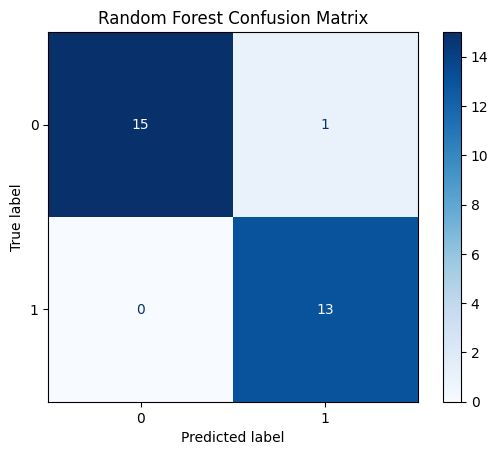

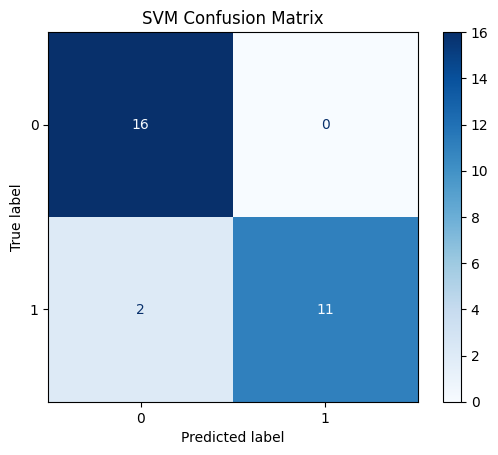

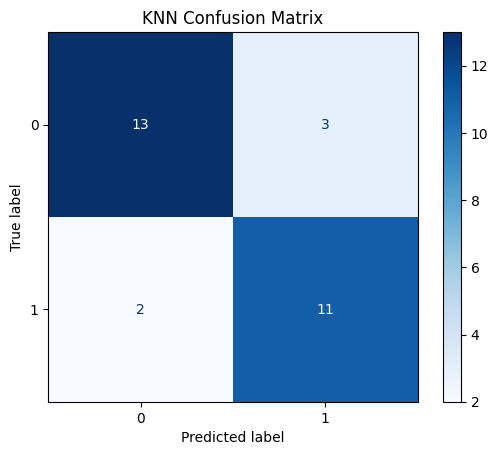

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")